# Advanced usage

### python test class


### config files

Provide option to input config files, in the form I want to get, if they don't provide any, you give/use default values. 
.txt format

Describe it in the documentation how it should look like.

In [1]:
from openTSNE import TSNEEmbedding
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger


import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


## Load data

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris["data"], iris["target"]

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 150 samples with 4 features


## Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

100 training samples
50 test samples


## Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization.

This example shows the standard t-SNE optimization. Much can be done in order to better preserve global structure and improve embedding quality. Please refer to the *preserving_global_structure* notebook for some examples.

**1. Compute the affinities between data points**

In [8]:
class KNNIndex_Elements:
    def __init__(self, metric, metric_params=None, n_jobs=1, random_state=None):
        self.index = None
        self.metric = metric
        self.metric_params = metric_params
        self.n_jobs = n_jobs
        self.random_state = random_state

    def build(self, data):
        """Build the index so we can query nearest neighbors."""

    def query_train(self, data, k):
        """Query the index for the points used to build index."""

    def query(self, query, k):
        """Query the index with new points."""

    def check_metric(self, metric):
        """Check that the metric is supported by the KNNIndex instance."""

### import multi_nearest_neighbors.py

### NearPy

In [8]:
import numpy

from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

# Dimension of our vector space
dimension = 500

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 10)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp])

# Index 1000000 random vectors (set their data to a unique string)
for index in range(100000):
    v = numpy.random.randn(dimension)
    engine.store_vector(v, 'data_%d' % index)

# Create random query vector
query = numpy.random.randn(dimension)

# Get nearest neighbours
N = engine.neighbours(query)

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

ImportError: numpy.core.multiarray failed to import

In [254]:
import nearpy
from nearpy.filters import NearestFilter
import sklearn.preprocessing

class NearPy(KNNIndex):
    #VALID_METRICS = neighbors.NearPy.valid_metrics
    #METHOD_PARAMS = neighbors.NearPy.params (text/config file)
    
    def build(self, data):        
        #parameters init
        if self.method_param == None:
            self.method_param = {}
            self.method_param['n_bits'] = 0.0 
            self.method_param['hash_counts'] = 0.0
            #self.method_param['filter'] = NearestFilter(10)
        self._filter = NearestFilter(10)
        self._metric = metric
        
        
        hashes = []

        for k in range(self._hash_counts):
            nearpy_rbp = nearpy.hashes.RandomBinaryProjections(
                'rbp_%d' % k, self._n_bits)
            hashes.append(nearpy_rbp)

        if self._metric == 'euclidean':
            dist = nearpy.distances.EuclideanDistance()
            self._nearpy_engine = nearpy.Engine(
                data.shape[1],
                lshashes=hashes,
                distance=dist)
        else:  # Default (angular) = Cosine distance
            self._nearpy_engine = nearpy.Engine(
                data.shape[1],
                lshashes=hashes,
                vector_filters=[self._filter])

        if self._metric == 'angular':
            data = sklearn.preprocessing.normalize(X, axis=1, norm='l2')
        for i, x in enumerate(data):
            self._nearpy_engine.store_vector(x, i)


    def query_train(self, data, k):
        self._filter.N = k
        if self._metric == 'angular':
            v = sklearn.preprocessing.normalize([v], axis=1, norm='l2')[0]
        return [y for x, y, z in self._nearpy_engine.neighbours(v)]


    def query(self, query, k):
        self._filter.N = k
        if self._metric == 'angular':
            v = sklearn.preprocessing.normalize([v], axis=1, norm='l2')[0]
        return [y for x, y, z in self._nearpy_engine.neighbours(v)]

### ONNG:

In [6]:
#from __future__ import absolute_import
import ngtpy
import numpy as np

class ONNG(KNNIndex):
    #VALID_METRICS = neighbors.ONNG.valid_metrics
    
    def build(self, data):
        #metrics = {'euclidean': '2', 'angular': 'C'}
        self._metric = metrics[metric]
        self._object_type
        self._edge_size_for_search = -2
        self._build_time_limit = 4
        self._epsilon = epsilon
        if self.method_param == None:
            self.method_param['edge'] == 0.0
            self.method_param['outdegree'] == 0.0
            self.method_param['indegree'] == 0.0

        dim = len(data[0])
        index_dir = 'indexes'
        if not os.path.exists(index_dir):
            os.makedirs(index_dir)
        index = os.path.join(
            index_dir,
            'ONNG-{}-{}-{}'.format(self._edge_size, self._outdegree,
                                   self._indegree))
        anngIndex = os.path.join(index_dir, 'ANNG-' + str(self._edge_size))
        if (not os.path.exists(index)) and (not os.path.exists(anngIndex)):
            t = time.time()
            args = ['ngt', 'create', '-it', '-p8', '-b500', '-ga', '-of',
                    '-D' + self._metric, '-d' + str(dim),
                    '-E' + str(self._edge_size), '-S0',
                    '-e' + str(self._epsilon), '-P0', '-B30',
                    '-T' + str(self._build_time_limit), anngIndex]
            subprocess.call(args)
            idx = ngtpy.Index(path=anngIndex)
            idx.batch_insert(X, num_threads=24, debug=False)
            idx.save()
            idx.close()
        if not os.path.exists(index):
            t = time.time()
            args = ['ngt', 'reconstruct-graph', '-mS',
                    '-o ' + str(self._outdegree),
                    '-i ' + str(self._indegree), anngIndex, index]
            subprocess.call(args)
        if os.path.exists(index):
            t = time.time()
            self.index = ngtpy.Index(index, read_only=True)
            self.indexName = index
        else:
            print('ONNG: Problem.')
        
            
    def query_train(self, data, k):    
        neighbors, distances = self.index.search(
            v, k, self._epsilon, self._edge_size_for_search,
            with_distance=False)
        return neighbors, distances
        
        
    def query(self, query, k):
        #check in what format results are, get neighbors, distances
        neighbors, distances = self.index.search(
            v, k, self._epsilon, self._edge_size_for_search,
            with_distance=False)
        return neighbors, distances

ModuleNotFoundError: No module named 'ngtpy'

### FLANN:

In [ ]:
class FLANN(KNNIndex):
    #VALID_METRICS = neighbors.Flann.valid_metrics
    
    def build(self, data):
        #parameters init
        if self.method_param == None:
            self.method_param = {}
            self.method_param['target_precision'] = 0.9  # want 90% target precision  
        self._metric = metric
        
        self.index = pyflann.FLANN(
            target_precision=self._target_precision,
            algorithm='autotuned', 
            log_level='info')
        if self._metric == 'angular':
            data = sklearn.preprocessing.normalize(data, axis=1, norm='l2')
        self.index.build_index(data)


###### 
    def query_train(self, data, k):
        if self._metric == 'angular':
            v = sklearn.preprocessing.normalize([v], axis=1, norm='l2')[0]
        if v.dtype != numpy.float32:
            v = v.astype(numpy.float32)
        return self._flann.nn_index(v, n)[0][0]

    def query(self, query, k):
        if self._metric == 'angular':
            v = sklearn.preprocessing.normalize([v], axis=1, norm='l2')[0]
        if v.dtype != numpy.float32:
            v = v.astype(numpy.float32)
        return self._flann.nn_index(v, n)[0][0]

### RPForest:

In [ ]:
import rpforest
import numpy


class RPForest(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self, data):
        n_trees = 5 + int(round((data.shape[0]) ** 0.5 / 20))
        #n_iters = max(5, int(round(np.log2(data.shape[0]))))
        leaf_size = ?
        
        self.index = rpforest.RPForest(leaf_size=leaf_size, no_trees=n_trees)
        
        #if data.dtype != numpy.double:
        #    data = numpy.array(data).astype(numpy.double)
        self.index.fit(data)

    def query_train(self, data, k):
        neighbors, distances = self._model.query(data[0], k)
        return neighbors, distances

    def query(self, query, k):
        neighbors, distances = self._model.query(data[0], k)
        return neighbors, distances

### Hnswlib:

In [28]:
%time

import hnswlib
import numpy as np


class HnswLib(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self,data):  
        #parameter init
        #self.metric = {'angular': 'cosine', 'euclidean': 'l2'}[metric]
        if self.method_param == None:
            self.method_param = {}
            self.method_param["efConstruction"] = 200
            self.method_param["M"] = 16
            self.method_param["efRecall"] = 10
            #self.name = 'hnswlib (%s)' % (self.method_param)
        
        
        self.index = hnswlib.Index(space=self.metric, dim=len(data[0]))
        self.index.init_index(max_elements=len(data),
                          ef_construction=self.method_param["efConstruction"],
                          M=self.method_param["M"])
        data_labels = np.arange(len(data))
        self.index.add_items(np.asarray(data), data_labels)
        self.index.set_num_threads(self.n_jobs)
        self.index.set_ef(self.method_param["efRecall"])

    def query(self, query, k):
        neighbors, distances = self.index.knn_query(query, k=k)
        return neighbors, distances
    
    def query_train(self, data, k):
        neighbors, distances = self.index.knn_query(data, k=k)
        return neighbors, distances

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


ModuleNotFoundError: No module named 'hnswlib'

### Annoy:

In [300]:
from openTSNE.nearest_neighbors import KNNIndex
import annoy
import numpy as np

class Annoy(KNNIndex):
    #VALID_METRICS = neighbors.Annoy.valid_metrics
    
    def build(self, data):
        num_items, vector_length = data.shape
        self.index = annoy.AnnoyIndex(vector_length, metric=self.metric)
        n_trees = 5 + int(round((data.shape[0]) ** 0.5 / 20))
        for i in range(num_items):
            self.index.add_item(i, data[i])
        self.index.build(n_trees)
        
    def query_train(self, data, k):
        #add search_k parameter: tradeoff between speed and accuracy?
        #neighbors_single, distances_single = np.asarray(self.index.get_nns_by_vector(data[i], n=k, search_k=-1, include_distances=True))
        #output array with points x neighbors:
        neighbors = np.empty((data.shape[0],k), dtype=int)
        distances = np.empty((data.shape[0],k))
        for i in range(len(data)):
            neighbors_single, distances_single = np.asarray(self.index.get_nns_by_item(i, n=k, search_k=-1 ,include_distances=True))
            neighbors[i] = neighbors_single
            distances[i] = distances_single
        return neighbors, distances

    def query(self, query, k):
        neighbors = np.empty((query.shape[0],k), dtype=int)
        distances = np.empty((query.shape[0],k))
        for i in range(len(query)):
            neighbors_single, distances_single = np.asarray(self.index.get_nns_by_vector(query[i], n=k, search_k=-1, include_distances=True))
            neighbors[i] = neighbors_single
            distances[i] = distances_single
        return neighbors, distances

### Test:

In [301]:
affinities_train = MultiANNPerplexityBasedNN(
    x,
    perplexity=30,
    method="annoy",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

#possible solution
#affinities_train.knn_index = stelmach.build_knn_index()

print("P:")
print(affinities_train.P)
print("")

#print("data:")
#print(affinities_train.data)
#print("")

print("knn_index:")
print(affinities_train.knn_index)

#print(".index")
#print(affinities_train.index)


P:
  (0, 58)	1.1123856191126478e-48
  (0, 63)	1.629381818051472e-47
  (0, 73)	1.5443295993298925e-46
  (0, 65)	7.618908252567122e-46
  (0, 87)	1.2659956581135655e-45
  (0, 51)	1.361279451433849e-45
  (0, 75)	3.7587606280968164e-45
  (0, 91)	4.041633163961909e-45
  (0, 106)	5.024286834345004e-45
  (0, 78)	1.1373116778461108e-43
  (0, 85)	2.0320429640373955e-43
  (0, 66)	1.4684333760073635e-41
  (0, 74)	3.770849500982889e-41
  (0, 55)	3.7708940636562237e-41
  (0, 84)	4.687778032095442e-41
  (0, 97)	1.2268324422718476e-39
  (0, 90)	6.052593783026402e-39
  (0, 61)	3.2721531985417874e-37
  (0, 94)	1.0645757646313081e-35
  (0, 62)	1.4229865461859848e-35
  (0, 96)	3.654254097655959e-35
  (0, 53)	1.55931299641511e-34
  (0, 71)	3.463470407810223e-34
  (0, 95)	3.724106684873443e-34
  (0, 99)	7.692885885901127e-34
  :	:
  (149, 66)	7.330878315897751e-05
  (149, 116)	7.599730076727377e-05
  (149, 78)	7.033520848381596e-05
  (149, 56)	0.00010558619198568894
  (149, 91)	8.089484542949024e-05
  (149,

In [259]:
affinities_train = MultiANNPerplexityBasedNN(
    x,
    perplexity=30,
    method="approx",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

#possible solution
#affinities_train.knn_index = stelmach.build_knn_index()

print("P:")
print(affinities_train.P)
print("")

#print("data:")
#print(affinities_train.data)
#print("")

print("knn_index:")
print(affinities_train.knn_index)

#print(".index")
#print(affinities_train.index)


Neighbors:
[[ 17   4  28 ...  63  58  68]
 [ 12  45  34 ...  65  63  58]
 [ 47   3   6 ...  65  68  58]
 ...
 [110 111 145 ...  59  64 131]
 [136 115 110 ...  53  64  69]
 [127 138 142 ... 107 109 135]]
Distances:
[[0.10000001 0.14142122 0.14142122 ... 3.69999975 3.74966645 3.76828862]
 [0.14142129 0.1414213  0.14142131 ... 3.69999985 3.71214194 3.78813912]
 [0.14142131 0.24494903 0.26457514 ... 3.88072164 3.89615202 3.97492132]
 ...
 [0.2236068  0.34641021 0.36055499 ... 1.95703851 1.96723154 2.00997534]
 [0.24494903 0.30000019 0.55677664 ... 2.15870338 2.2022717  2.20454074]
 [0.28284245 0.31622746 0.33166242 ... 1.84661878 1.88148856 2.11896179]]
P:
  (0, 68)	1.6192509157967902e-47
  (0, 58)	4.313007103779627e-47
  (0, 63)	5.7441069565559964e-46
  (0, 73)	5.0271385917781364e-45
  (0, 65)	2.3437119481052305e-44
  (0, 87)	3.82501882591911e-44
  (0, 51)	4.1022817234324965e-44
  (0, 75)	1.0926730616423587e-43
  (0, 91)	1.1718826756182114e-43
  (0, 106)	1.445613427848103e-43
  (0, 78)	2.

### import affinity_multiann.py

In [272]:
import logging
import operator
from functools import reduce

import numpy as np
import scipy.sparse as sp

#from . import nearest_neighbors

log = logging.getLogger(__name__)

from openTSNE.affinity import PerplexityBasedNN, MultiscaleMixture, FixedSigmaNN, joint_probabilities_nn
from openTSNE import nearest_neighbors

class MultiANNPerplexityBasedNN(PerplexityBasedNN):
    """Compute affinities using nearest neighbors.
    """

    #super init !    
    def __init__(
        self,
        data,
        perplexity=30,
        method="approx",
        metric="euclidean",
        metric_params=None,
        symmetrize=True,
        n_jobs=1,
        random_state=None,
    ):
        self.n_samples = data.shape[0]
        self.perplexity = self.check_perplexity(perplexity)

        self.knn_index = build_knn_index(
            data, method, metric, metric_params, n_jobs, random_state
        )

        # Find and store the nearest neighbors so we can reuse them if the
        # perplexity is ever lowered
        k_neighbors = min(self.n_samples - 1, int(3 * self.perplexity))
        self.__neighbors, self.__distances = self.knn_index.query_train(
            data, k=k_neighbors
        )
        #print("Neighbors:")
        #print(self.__neighbors)
        #print(len(self.__neighbors))
        #print("Distances:")
        #print(self.__distances)
        #print(len(self.__distances[0]))

        self.P = joint_probabilities_nn(
            self.__neighbors,
            self.__distances,
            [self.perplexity],
            symmetrize=symmetrize,
            n_jobs=n_jobs,
        )

        self.n_jobs = n_jobs
        
        
        
def build_knn_index(
    data, method, metric, metric_params=None, n_jobs=1, random_state=None
):
    methods = {
        "exact_alt": nearest_neighbors.VPTree,
        "exact": nearest_neighbors.BallTree,
        "approx": nearest_neighbors.NNDescent,
        #cs: options for ann algorithms
        "balltree": nearest_neighbors.BallTree,
        "nndescent": nearest_neighbors.NNDescent,
        #"annoy": multi_nearest_neighbors.Annoy, (if filelocation in sumfile)
        #"annoy": algorithms.annoy.Annoy (if filelocation in folder)
        "annoy": Annoy,
        #"hnswlib": Hnswlib,
        #"rpforest": RPForest,
        #"flann": FLANN,
        #"onng": ONNG,
        #"nearpy": NearPy,
    }
    if isinstance(method, nearest_neighbors.KNNIndex):
        knn_index = method

    elif method not in methods:
        raise ValueError(
            "Unrecognized nearest neighbor algorithm `%s`. "
            "Please choose one of the supported methods or "
            "provide a valid `KNNIndex` instance." % method
        )
    else:
        knn_index = methods[method](
            metric=metric,
            metric_params=metric_params,
            n_jobs=n_jobs,
            random_state=random_state,
        )

    knn_index.build(data)

    return knn_index        

In [273]:
# class MultiANNFixedSigmaNN(FixedSigmaNN):
#     """Compute affinities using using nearest neighbors and a fixed bandwidth
#     for the Gaussians in the ambient space.
# 
#     Using a fixed Gaussian bandwidth can enable us to find smaller clusters of
#     data points than we might be able to using the automatically determined
#     bandwidths using perplexity. Note however that this requires mostly trial
#     and error.
#     """
# 
#     def __init__(
#         self,
#         data,
#         sigma,
#         k=30,
#         method="exact",
#         metric="euclidean",
#         metric_params=None,
#         symmetrize=True,
#         n_jobs=1,
#         random_state=None,
#     ):
#         self.n_samples = n_samples = data.shape[0]
# 
#         if k >= self.n_samples:
#             raise ValueError(
#                 "`k` (%d) cannot be larger than N-1 (%d)." % (k, self.n_samples)
#             )
# 
#         knn_index, neighbors, distances = build_knn_index(
#             data, method, k, metric, metric_params, n_jobs, random_state
#         )
# 
#         self.knn_index = knn_index
# 
#         # Compute asymmetric pairwise input similarities
#         conditional_P = np.exp(-distances ** 2 / (2 * sigma ** 2))
#         conditional_P /= np.sum(conditional_P, axis=1)[:, np.newaxis]
# 
#         P = sp.csr_matrix(
#             (conditional_P.ravel(), neighbors.ravel(), range(0, n_samples * k + 1, k)),
#             shape=(n_samples, n_samples),
#         )
# 
#         # Symmetrize the probability matrix
#         if symmetrize:
#             P = (P + P.T) / 2
# 
#         # Convert weights to probabilities
#         P /= np.sum(P)
# 
#         self.sigma = sigma
#         self.k = k
#         self.P = P
#         self.n_jobs = n_jobs
#
#
# class MultiANNMultiscaleMixture(MultiscaleMixture):
#     """Calculate affinities using a Gaussian mixture kernel.
# 
#     Instead of using a single perplexity to compute the affinities between data
#     points, we can use a multiscale Gaussian kernel instead. This allows us to
#     incorporate long range interactions.
#     """
# 
#     def __init__(
#         self,
#         data,
#         perplexities,
#         method="exact",
#         metric="euclidean",
#         metric_params=None,
#         symmetrize=True,
#         n_jobs=1,
#         random_state=None,
#     ):
#         self.n_samples = data.shape[0]
# 
#         # We will compute the nearest neighbors to the max value of perplexity,
#         # smaller values can just use indexing to truncate unneeded neighbors
#         perplexities = self.check_perplexities(perplexities)
#         max_perplexity = np.max(perplexities)
#         k_neighbors = min(self.n_samples - 1, int(3 * max_perplexity))
# 
#         self.knn_index, self.__neighbors, self.__distances = build_knn_index(
#             data, method, k_neighbors, metric, metric_params, n_jobs, random_state
#         )
# 
#         self.P = self._calculate_P(
#             self.__neighbors,
#             self.__distances,
#             perplexities,
#             symmetrize=symmetrize,
#             n_jobs=n_jobs,
#         )
# 
#         self.perplexities = perplexities
#         self.n_jobs = n_jobs
# 
# class MultiANNMultiscale(MultiANNMultiscaleMixture):
#     """Calculate affinities using averaged Gaussian perplexities.
# 
#     In contrast to :class:`MultiscaleMixture`, which uses a Gaussian mixture
#     kernel, here, we first compute single scale Gaussian kernels, convert them
#     to probability distributions, then average them out between scales.
# 
#     Please see the :ref:`parameter-guide` for more information.
#     """
# 
#     @staticmethod
#     def _calculate_P(
#         neighbors,
#         distances,
#         perplexities,
#         symmetrize=True,
#         normalization="pair-wise",
#         n_reference_samples=None,
#         n_jobs=1,
#     ):
#         # Compute normalized probabilities for each perplexity
#         partial_Ps = [
#             joint_probabilities_nn(
#                 neighbors,
#                 distances,
#                 [perplexity],
#                 symmetrize=symmetrize,
#                 normalization=normalization,
#                 n_reference_samples=n_reference_samples,
#                 n_jobs=n_jobs,
#             )
#             for perplexity in perplexities
#         ]
#         # Sum them together, then normalize
#         P = reduce(operator.add, partial_Ps, 0)
# 
#         # Take care to properly normalize the affinity matrix
#         if normalization == "pair-wise":
#             P /= np.sum(P)
#         elif normalization == "point-wise":
#             P = sp.diags(np.asarray(1 / P.sum(axis=1)).ravel()) @ P
# 
#         return P

**2. Generate initial coordinates for our embedding**

In [281]:
%time init_train = initialization.pca(x_train, random_state=42)

CPU times: user 822 µs, sys: 110 µs, total: 932 µs
Wall time: 845 µs


**3. Construct the `TSNEEmbedding` object**

In [302]:
%time 
affinities_train = MultiANNPerplexityBasedNN(
    x_train,
    perplexity=30,
    method="annoy",
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)


%time

embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


**4. Optimize embedding**

1. Early exaggeration phase

In [303]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  1.2475, 50 iterations in 1.5289 sec
Iteration  100, KL divergence  1.4590, 50 iterations in 1.5166 sec
Iteration  150, KL divergence  1.4685, 50 iterations in 1.5120 sec
Iteration  200, KL divergence  1.4362, 50 iterations in 1.4247 sec
Iteration  250, KL divergence  1.5032, 50 iterations in 1.5110 sec
CPU times: user 6.77 s, sys: 290 ms, total: 7.06 s
Wall time: 7.52 s


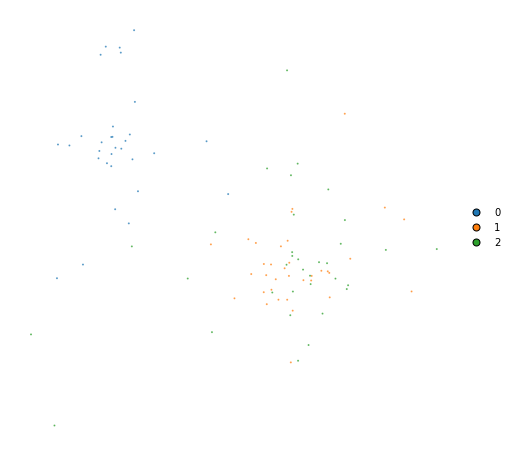

In [304]:
import utils

utils.plot(embedding_train_1, y_train)

In [305]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)

Iteration   50, KL divergence  0.2279, 50 iterations in 1.6473 sec
Iteration  100, KL divergence  0.0347, 50 iterations in 1.5687 sec
Iteration  150, KL divergence -0.0025, 50 iterations in 1.1931 sec
Iteration  200, KL divergence -0.0020, 50 iterations in 0.8442 sec
Iteration  250, KL divergence -0.0021, 50 iterations in 1.0553 sec
Iteration  300, KL divergence -0.0045, 50 iterations in 1.0529 sec
Iteration  350, KL divergence -0.0035, 50 iterations in 0.8970 sec
Iteration  400, KL divergence -0.0040, 50 iterations in 0.8426 sec
Iteration  450, KL divergence -0.0049, 50 iterations in 0.8446 sec
Iteration  500, KL divergence -0.0052, 50 iterations in 0.9249 sec
Iteration  550, KL divergence -0.0021, 50 iterations in 0.8454 sec
Iteration  600, KL divergence -0.0029, 50 iterations in 0.8775 sec
Iteration  650, KL divergence -0.0044, 50 iterations in 0.8263 sec
Iteration  700, KL divergence -0.0036, 50 iterations in 0.8493 sec
Iteration  750, KL divergence -0.0043, 50 iterations in 0.7805

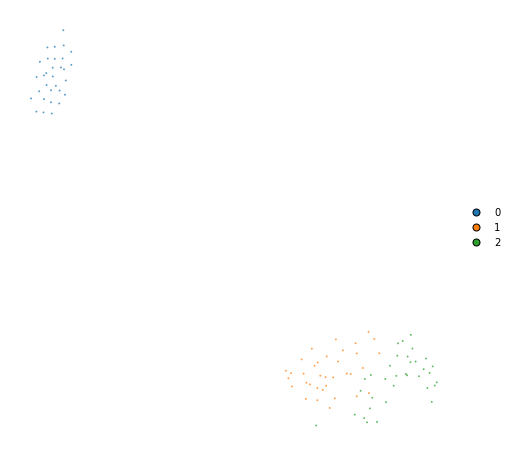

In [306]:
utils.plot(embedding_train_2, y_train)

## Transform

In [307]:
%%time
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)

CPU times: user 7.86 ms, sys: 2.2 ms, total: 10.1 ms
Wall time: 6.77 ms


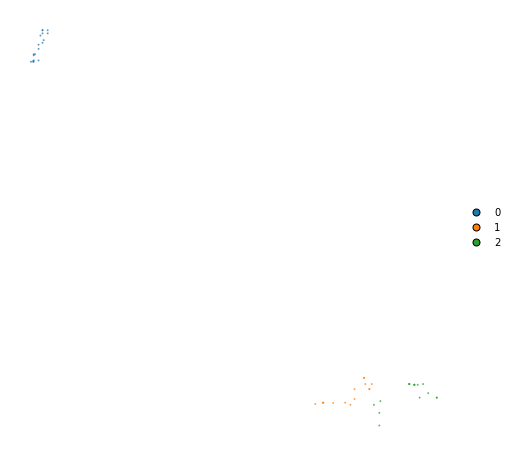

In [308]:
utils.plot(embedding_test, y_test)

In [309]:
%%time
embedding_test_1 = embedding_test.optimize(
    n_iter=100,
    learning_rate=1,
    exaggeration=2,
    momentum=0,
)

CPU times: user 698 ms, sys: 17.4 ms, total: 715 ms
Wall time: 897 ms


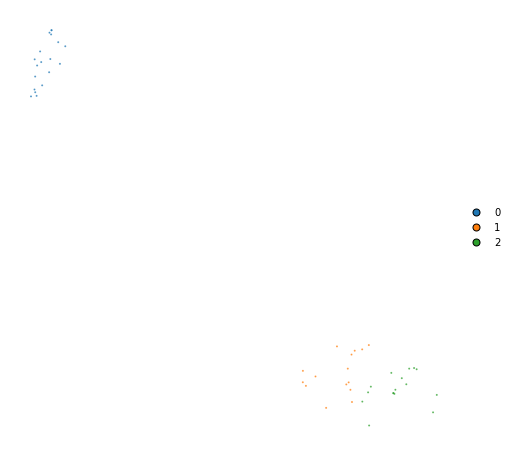

In [310]:
utils.plot(embedding_test_1, y_test)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

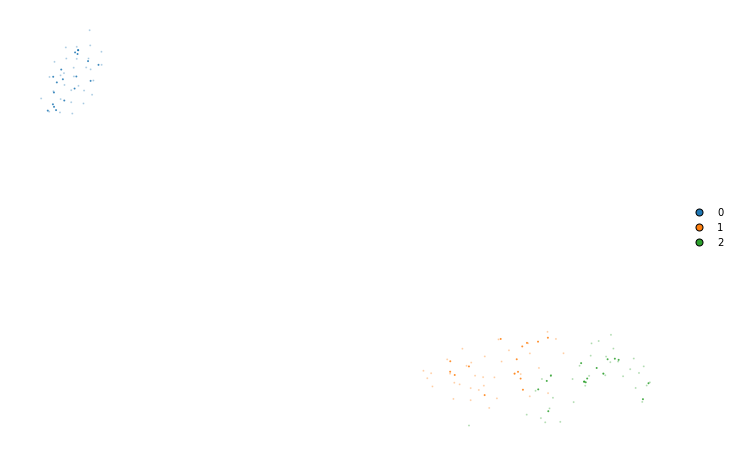

In [311]:
fig, ax = plt.subplots(figsize=(12, 8))
utils.plot(embedding_train_2, y_train, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, alpha=0.75, ax=ax)

---

### Test inheritance:

In [46]:
class base():
    def __init__(self):
        init = "Init Base"
        print(init)
    def bark(self):
        print("woof")
        
#currently (full override):
class over(base):
    def __init__(self):
        init = "Init Previous"
        print(init)
    def berk(self):
        print("dog.bark(self)")

billo = dug()  

#with super:
class sup(base):
    def __init__(self):
        super(deg, self).__init__()
        init = "Init Super"
        print(init)
    def berk(self):
        print("dog.bark(self)")

bello = deg()

Init Previous
Init Base
Init Super


### Test numpy array:

In [127]:
import numpy as np

print("x.shape: {}".format(x.shape))
arr = np.empty(x.shape)
#print("arr: {}".format(arr))
entry = [0,1,2,3]
arr[0] = entry
print("arr + entry {}".format(arr[0]))

x.shape: (150, 4)
arr + entry [0. 1. 2. 3.]


In [229]:
import numpy as np

#index = neighbors, distances
data = [[[0,1,2,3],[0,20,30,40]],[[1,1,2,3],[10,20,30,40]],[[2,1,2,3],[20,20,30,40]],
[[3,1,2,3],[30,20,30,40]],[[4,1,2,3],[40,20,30,40]]]

neighbors = np.empty((5,4))
distances = np.empty((5,4))

for i in range(len(data)):
    #neighbors_single, distances_single = np.asarray(data[i])
    neighbors[i], distances[i] = np.asarray(data[i])
#    neighbors[i] = neighbors_single
#    distances[i] = distances_single
      
print(neighbors)
print(distances)






#indexarr = np.asarray(indexlist)
#np.append(indexarr[1],np.asarray(indexlist1)[1], axis=0)
#neig, dist = indexarr[1]
#np.append(indexarr[0],np.asarray(indexlist1)[1], axis=0)

#print(indexarr)


#neigh = np.empty((4,4))
#dist = np.empty

#empty[0] = indexarr[0]
#print("")
#print(empty)




[[0. 1. 2. 3.]
 [1. 1. 2. 3.]
 [2. 1. 2. 3.]
 [3. 1. 2. 3.]
 [4. 1. 2. 3.]]
[[ 0. 20. 30. 40.]
 [10. 20. 30. 40.]
 [20. 20. 30. 40.]
 [30. 20. 30. 40.]
 [40. 20. 30. 40.]]
